In [1]:
from pathlib import Path
from kedro.framework.context import load_context

current_dir = Path.cwd()
proj_path = current_dir.parent
context = load_context(proj_path)

c:\users\valxa\anaconda3\envs\splatoon-ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
import warnings


In [3]:
# head 等で表示した際に省略されないようにする
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", 10000)

# warningを表示しないようにする
warnings.filterwarnings('ignore')

c:\users\valxa\anaconda3\envs\splatoon-ml\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df_train = catalog.load("train")
df_test = catalog.load("test")
df_stage = catalog.load("stagedata")
df_weapon = catalog.load("weapon")


players = ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4"]

2020-10-04 12:24:46,212 - kedro.io.data_catalog - INFO - Loading data from `train` (CSVDataSet)...
2020-10-04 12:24:46,404 - kedro.io.data_catalog - INFO - Loading data from `test` (CSVDataSet)...
2020-10-04 12:24:46,491 - kedro.io.data_catalog - INFO - Loading data from `stagedata` (CSVDataSet)...
2020-10-04 12:24:46,494 - kedro.io.data_catalog - INFO - Loading data from `weapon` (CSVDataSet)...


In [5]:
FOLD_NUM = 10

In [6]:
onehot_cols = ['lobby-mode', 'mode', 'stage',
              'A1-mainweapon', 'A1-subweapon', 'A1-special',
              'A2-mainweapon', 'A2-subweapon', 'A2-special', 
              'A3-mainweapon', 'A3-subweapon', 'A3-special', 
              'A4-mainweapon', 'A4-subweapon', 'A4-special', 
              'B1-mainweapon', 'B1-subweapon', 'B1-special', 
              'B2-mainweapon', 'B2-subweapon', 'B2-special', 
              'B3-mainweapon', 'B3-subweapon', 'B3-special', 
              'B4-mainweapon', 'B4-subweapon', 'B4-special', 
              ]

te_cat_cols = ['A1-mainweapon', 'A1-subweapon', 'A1-special',
              'A2-mainweapon', 'A2-subweapon', 'A2-special', 
              'A3-mainweapon', 'A3-subweapon', 'A3-special', 
              'A4-mainweapon', 'A4-subweapon', 'A4-special', 
              'B1-mainweapon', 'B1-subweapon', 'B1-special', 
              'B2-mainweapon', 'B2-subweapon', 'B2-special', 
              'B3-mainweapon', 'B3-subweapon', 'B3-special', 
              'B4-mainweapon', 'B4-subweapon', 'B4-special', 
              ]


In [7]:
def disconnect_player_cnt(data):
    temp_data = data.copy()
    temp_data = temp_data.isnull()
    data["A-disconnect"] = temp_data["A1-weapon"].astype("int") + temp_data["A2-weapon"].astype("int") + temp_data["A3-weapon"].astype("int") + temp_data["A4-weapon"].astype("int")
    data["A-connect"] = 4 - data["A-disconnect"]
    data["B-disconnect"] = temp_data["B1-weapon"].astype("int") + temp_data["B2-weapon"].astype("int") + temp_data["B3-weapon"].astype("int") + temp_data["B4-weapon"].astype("int")
    data["B-connect"] = 4 - data["B-disconnect"]
    return data
    

In [8]:
def rank_to_value(x):
    rank = {'c-': 2.0, 'c': 2.3, 'c+': 2.6,
            'b-': 3, 'b': 3.3, 'b+': 3.6,
            'a-': 4, 'a': 4.3, 'a+': 4.6,
            's': 5, 's+': 5.5, 'x': 6
            }
    if x in rank:
        x = rank[x]
    else:
        x = 0
    return x

In [9]:
def regular_rank(data):
    players = ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4"]
    for index, row in data.iterrows():
        if row["lobby-mode"] == "regular":
            for player in players:
                data.at[index, f"{player}-rank"] = 1
    return data


In [10]:
def rank_average(data):
    data["A-rank-ave"] = (data["A1-rank"] + data["A2-rank"] + data["A3-rank"] + data["A4-rank"]) / data["A-connect"]
    data["B-rank-ave"] = (data["B1-rank"] + data["B2-rank"] + data["B3-rank"] + data["B4-rank"]) / data["B-connect"]
    return data

In [11]:
def OneHot_encoder(x, col_list):
    import category_encoders as ce
    ce_ohe = ce.OneHotEncoder(cols=col_list, handle_unknown='impute')
    return ce_ohe.fit_transform(x)
    

In [12]:
def target_encoder_test(train_x, train_y, test_x, cat_cols):
    for c in cat_cols:
        data_tmp = pd.DataFrame({c: train_x[c], 'target': train_y})
        target_mean = data_tmp.groupby(c)['target'].mean()
        
        test_x.loc[:, c] = test_x[c].map(target_mean)
        
    return test_x
            

In [13]:
def target_encoder(train_x, train_y, valid_x, cat_cols):
    from sklearn.model_selection import KFold
    
    for c in cat_cols:
        data_tmp = pd.DataFrame({c: train_x[c], 'target': train_y})
        target_mean = data_tmp.groupby(c)['target'].mean()
        
        valid_x.loc[:, c] = valid_x[c].map(target_mean)
        
        tmp = np.repeat(np.nan, train_x.shape[0])
        
        kf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=1234)
        
        for idx_1, idx_2 in kf.split(train_x, train_y):
            target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
            tmp[idx_2] = train_x[c].iloc[idx_2].map(target_mean)
        train_x.loc[:,c] = tmp
    return train_x, valid_x
            

In [14]:
def level_average(data):
    data["A-level-ave"] = (data["A1-level"] + data["A2-level"] + data["A3-level"] + data["A4-level"]) / data["A-connect"]
    data["B-level-ave"] = (data["B1-level"] + data["B2-level"] + data["B3-level"] + data["B4-level"]) / data["B-connect"]
    return data

In [15]:
def data_augmentation(data):
    import random
    temp_data = data.copy()
    temp_data = temp_data.dropna()
    A_team = ["A1", "A2", "A3", "A4"]
    B_team = ["B1", "B2", "B3", "B4"]
    for index, row in temp_data.iterrows():
        rand_A = random.sample(A_team, 4)
        temp_data.at[index,"A1-weapon"], temp_data.at[index,"A2-weapon"], temp_data.at[index,"A3-weapon"], temp_data.at[index,"A4-weapon"] = \
            row[f"{rand_A[0]}-weapon"], row[f"{rand_A[1]}-weapon"], row[f"{rand_A[2]}-weapon"], row[f"{rand_A[3]}-weapon"]
        temp_data.at[index,"A1-rank"], temp_data.at[index,"A2-rank"], temp_data.at[index,"A3-rank"], temp_data.at[index,"A4-rank"] = \
            row[f"{rand_A[0]}-rank"], row[f"{rand_A[1]}-rank"], row[f"{rand_A[2]}-rank"], row[f"{rand_A[3]}-rank"]
        temp_data.at[index,"A1-level"], temp_data.at[index,"A2-level"], temp_data.at[index,"A3-level"], temp_data.at[index,"A4-level"] = \
            row[f"{rand_A[0]}-level"], row[f"{rand_A[1]}-level"], row[f"{rand_A[2]}-level"], row[f"{rand_A[3]}-level"]

        rand_B = random.sample(B_team, 4)
        temp_data.at[index,"B1-weapon"], temp_data.at[index,"B2-weapon"], temp_data.at[index,"B3-weapon"], temp_data.at[index,"B4-weapon"] = \
            row[f"{rand_B[0]}-weapon"], row[f"{rand_B[1]}-weapon"], row[f"{rand_B[2]}-weapon"], row[f"{rand_B[3]}-weapon"]
        temp_data.at[index,"B1-rank"], temp_data.at[index,"B2-rank"], temp_data.at[index,"B3-rank"], temp_data.at[index,"B4-rank"] = \
            row[f"{rand_B[0]}-rank"], row[f"{rand_B[1]}-rank"], row[f"{rand_B[2]}-rank"], row[f"{rand_B[3]}-rank"]
        temp_data.at[index,"B1-level"], temp_data.at[index,"B2-level"], temp_data.at[index,"B3-level"], temp_data.at[index,"B4-level"] = \
            row[f"{rand_B[0]}-level"], row[f"{rand_B[1]}-level"], row[f"{rand_B[2]}-level"], row[f"{rand_B[3]}-level"]
    data = pd.concat([data, temp_data])
    return data

In [16]:
def merge_weapon(data, weapondata):
    weapons = [p + "-weapon" for p in players]
    for weapon in weapons:
        temp_weapon_detail = data[[weapon]].join(weapondata.set_index("key"), on=weapon)
        weapon_detail = [weapon[:3] + col for col in temp_weapon_detail.columns]
        temp_weapon_detail.columns = weapon_detail
        data = pd.concat([data, temp_weapon_detail], axis=1)
        data = data.drop(weapon[:3] + weapon, axis=1)
        data = data.drop(weapon[:3] + 'i', axis=1)
        data = data.drop(weapon, axis=1)
    return data

In [17]:
def range_average(data):
    data["A-range-ave"] = (data["A1-range"] + data["A2-range"] + data["A3-range"] + data["A4-range"]) / data["A-connect"]
    data["B-range-ave"] = (data["B1-range"] + data["B2-range"] + data["B3-range"] + data["B4-range"]) / data["B-connect"]
    return data

In [18]:
def damage_average(data):
    data["A-damage-ave"] = (data["A1-damage"] + data["A2-damage"] + data["A3-damage"] + data["A4-damage"]) / data["A-connect"]
    data["B-damage-ave"] = (data["B1-damage"] + data["B2-damage"] + data["B3-damage"] + data["B4-damage"]) / data["B-connect"]
    return data

In [19]:
def rate_average(data):
    data["A-rate-ave"] = (data["A1-rate"] + data["A2-rate"] + data["A3-rate"] + data["A4-rate"]) / data["A-connect"]
    data["B-rate-ave"] = (data["B1-rate"] + data["B2-rate"] + data["B3-rate"] + data["B4-rate"]) / data["B-connect"]
    return data

In [20]:
def ability_to_value(data):
    players = ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4"]
    for player in players:
        data[f"{player}-ability"] = data[f"{player}-level"] * data[f"{player}-rank"]
    return data

In [21]:
def ability_average(data):
    data["A-ability-ave"] = (data["A1-ability"] + data["A2-ability"] + data["A3-ability"] + data["A4-ability"]) / data["A-connect"]
    data["B-ability-ave"] = (data["B1-ability"] + data["B2-ability"] + data["B3-ability"] + data["B4-ability"]) / data["B-connect"]
    return data    

In [22]:
def category_count(data):
    teams = ["A", "B"]
    A_team = ["A1", "A2", "A3", "A4"]
    B_team = ["B1", "B2", "B3", "B4"]
    for team in teams:
        data[f"{team}-shooter"] = 0
        data[f"{team}-blaster"] = 0
        data[f"{team}-maneuver"] = 0
        data[f"{team}-reelgun"] = 0
        data[f"{team}-roller"] = 0
        data[f"{team}-brush"] = 0
        data[f"{team}-charger"] = 0
        data[f"{team}-slosher"] = 0
        data[f"{team}-splatling"] = 0
        data[f"{team}-brella"] = 0

    category_list = ['A1-category', 'A2-category', 'A3-category', 'A4-category', 
                    'B1-category', 'B2-category', 'B3-category', 'B4-category', 
                    ]    
    temp_data = OneHot_encoder(data, category_list)
    for team in teams:
        data[f"{team}-shooter"] = temp_data[f"{team}1-category_1"] + temp_data[f"{team}2-category_1"] + temp_data[f"{team}3-category_1"] + temp_data[f"{team}4-category_1"]
        data[f"{team}-blaster"] = temp_data[f"{team}1-category_2"] + temp_data[f"{team}2-category_2"] + temp_data[f"{team}3-category_2"] + temp_data[f"{team}4-category_2"]
        data[f"{team}-maneuver"] = temp_data[f"{team}1-category_3"] + temp_data[f"{team}2-category_3"] + temp_data[f"{team}3-category_3"] + temp_data[f"{team}4-category_3"]
        data[f"{team}-reelgun"] = temp_data[f"{team}1-category_4"] + temp_data[f"{team}2-category_4"] + temp_data[f"{team}3-category_4"] + temp_data[f"{team}4-category_4"]
        data[f"{team}-roller"] = temp_data[f"{team}1-category_5"] + temp_data[f"{team}2-category_5"] + temp_data[f"{team}3-category_5"] + temp_data[f"{team}4-category_5"]
        data[f"{team}-brush"] = temp_data[f"{team}1-category_6"] + temp_data[f"{team}2-category_6"] + temp_data[f"{team}3-category_6"] + temp_data[f"{team}4-category_6"]
        data[f"{team}-charger"] = temp_data[f"{team}1-category_7"] + temp_data[f"{team}2-category_7"] + temp_data[f"{team}3-category_7"] + temp_data[f"{team}4-category_7"]
        data[f"{team}-slosher"] = temp_data[f"{team}1-category_8"] + temp_data[f"{team}2-category_8"] + temp_data[f"{team}3-category_8"] + temp_data[f"{team}4-category_8"]
        data[f"{team}-splatling"] = temp_data[f"{team}1-category_9"] + temp_data[f"{team}2-category_9"] + temp_data[f"{team}3-category_9"] + temp_data[f"{team}4-category_9"]
        data[f"{team}-brella"] = temp_data[f"{team}1-category_10"] + temp_data[f"{team}2-category_10"] + temp_data[f"{team}3-category_10"] + temp_data[f"{team}4-category_10"]
    
    return data    

In [23]:
def preprocess_weapon(weapon):
    weapon["category"] = weapon["category2"]
    weapon = weapon.drop(["category1", "category2"], axis=1)
    return weapon

In [24]:
def preprocess_stage(stagedata):
    return stagedata

In [25]:
def preprocess_data(train, test, weapon, stagedata):
    train = disconnect_player_cnt(train)
    train = data_augmentation(train)
    target = train['y']
    test = disconnect_player_cnt(test)
    data = pd.concat([train, test])
    
    # テーブルを結合
    players = ["A1", "A2", "A3", "A4", "B1", "B2", "B3", "B4"]
    data = data.join(stagedata.set_index("stage"), on="stage")
    data = merge_weapon(data, weapon)
    
    for player in players:
        data[f"{player}-rank"] = data[f"{player}-rank"].apply(rank_to_value)
        data[f"{player}-range"] = data[f"{player}-range"].fillna(0)
        data[f"{player}-damage"] = data[f"{player}-damage"].fillna(0)
        data[f"{player}-rate"] = data[f"{player}-rate"].fillna(0)
        data[f"{player}-level"] = data[f"{player}-level"].fillna(0)
    data = regular_rank(data)
    data = rank_average(data)
    data = level_average(data)
    data = range_average(data)
    data = damage_average(data)
    data = rate_average(data)
    data = ability_to_value(data)
    data = ability_average(data)
    data = category_count(data)
    data = OneHot_encoder(data, onehot_cols)
    return data, target

In [26]:
processed_weapon = preprocess_weapon(df_weapon)

In [27]:
processed_stage = preprocess_stage(df_stage)

In [28]:
processed_data, target = preprocess_data(df_train, df_test, processed_weapon, processed_stage)

In [29]:
def drop_column(data):
    drop_col = ["id", "period", "game-ver", "lobby",
               "A1-range", "A2-range", "A3-range", "A4-range", 
               "B1-range", "B2-range", "B3-range", "B4-range", 
               "A1-damage", "A2-damage", "A3-damage", "A4-damage", 
               "B1-damage", "B2-damage", "B3-damage", "B4-damage", 
               "A1-rate", "A2-rate", "A3-rate", "A4-rate", 
               "B1-rate", "B2-rate", "B3-rate", "B4-rate",
               "A1-level", "A2-level", "A3-level", "A4-level", 
               "B1-level", "B2-level", "B3-level", "B4-level",
               "A1-ability", "A2-ability", "A3-ability", "A4-ability", 
               "B1-ability", "B2-ability", "B3-ability", "B4-ability",
               "A1-rank", "A2-rank", "A3-rank", "A4-rank", 
               "B1-rank", "B2-rank", "B3-rank", "B4-rank",
               "A1-category", "A2-category", "A3-category", "A4-category", 
               "B1-category", "B2-category", "B3-category", "B4-category",
               ]
    data = data.drop(drop_col, axis=1)
    return data

In [30]:
def process_nan(data):
    data = data.fillna(0.0)
    return data

In [31]:
def create_master_table(data):
    master_table = drop_column(data)
    master_table = process_nan(master_table)
    train = master_table.iloc[:len(target), :]
    test = master_table.iloc[len(target):, :]
    test = test.drop('y', axis=1)
    train_x = train.drop('y', axis=1)
    train_y = train['y']
    
#    test = target_encoder_test(train_x, train_y, test, te_cat_cols)

    train_x = process_nan(train_x)
    test = process_nan(test)
    return train_x, train_y, test

In [32]:
train_x, train_y, test = create_master_table(processed_data)

In [33]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score


In [34]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_iterations': 1000,
    'early_stopping_rounds': 100,
}

In [35]:

kf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=1234)

scores = []

pred_cv = np.zeros(len(test.index))

num_round = 1000

for i, (tdx, vdx) in enumerate(kf.split(train_x, train_y)):
    print(f'Fold : {i}')
    # 訓練用データと検証用データに分割
    X_train, X_valid, y_train, y_valid = train_x.iloc[tdx], train_x.iloc[vdx], train_y.values[tdx], train_y.values[vdx]

#    X_train, X_valid = target_encoder(X_train, y_train, X_valid, te_cat_cols)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid)
    
    # 学習の実行
    model = lgb.train(params, lgb_train, num_boost_round=num_round,
                      valid_names=["train", "valid"], valid_sets=[lgb_train, lgb_valid],
                      verbose_eval=100)

    # 検証データに対する予測値を求めて、勝敗（０　or　１）に変換
    va_pred = np.round(model.predict(X_valid,num_iteration=model.best_iteration))
    
    # accuracyスコアを計算
    score_ = accuracy_score(y_valid, va_pred)
    
    # フォールド毎の検証時のスコアを格納
    scores.append(score_)
    
    #テストデータに対する予測値を求める
    submission = model.predict(test,num_iteration=model.best_iteration)
    
    #テストデータに対する予測値をフォールド数で割って蓄積
    #(フォールド毎の予測値の平均値を求めることと同じ)
    pred_cv += submission/FOLD_NUM

# 最終的なテストデータに対する予測値を勝敗（０　or　１）に変換
pred_cv = np.round(pred_cv)

# 最終的なaccuracyスコアを平均値で出力
print('')
print('################################')
print('CV_score:'+ str(np.mean(scores)))

Fold : 0
[LightGBM] [Info] Number of positive: 55191, number of negative: 50746
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3756
[LightGBM] [Info] Number of data points in the train set: 105937, number of used features: 681
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.520979 -> initscore=0.083967
[LightGBM] [Info] Start training from score 0.083967
Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.658928	valid's binary_logloss: 0.68231
[200]	train's binary_logloss: 0.63644	valid's binary_logloss: 0.679696
[300]	train's binary_logloss: 0.616441	valid's binary_logloss: 0.676964
[400]	train's binary_logloss: 0.597343	valid's binary_logloss: 0.674499
[500]	train's binary_logloss: 0.579858	valid's binary_logloss: 0.672555
[600]	trai

[400]	train's binary_logloss: 0.596316	valid's binary_logloss: 0.67744
[500]	train's binary_logloss: 0.578695	valid's binary_logloss: 0.675742
[600]	train's binary_logloss: 0.561635	valid's binary_logloss: 0.674077
[700]	train's binary_logloss: 0.545396	valid's binary_logloss: 0.672293
[800]	train's binary_logloss: 0.52963	valid's binary_logloss: 0.669968
[900]	train's binary_logloss: 0.514624	valid's binary_logloss: 0.668137
[1000]	train's binary_logloss: 0.500722	valid's binary_logloss: 0.666968
Did not meet early stopping. Best iteration is:
[1000]	train's binary_logloss: 0.500722	valid's binary_logloss: 0.666968
Fold : 6
[LightGBM] [Info] Number of positive: 55192, number of negative: 50745
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3761
[LightGBM] [Info] Number of data 

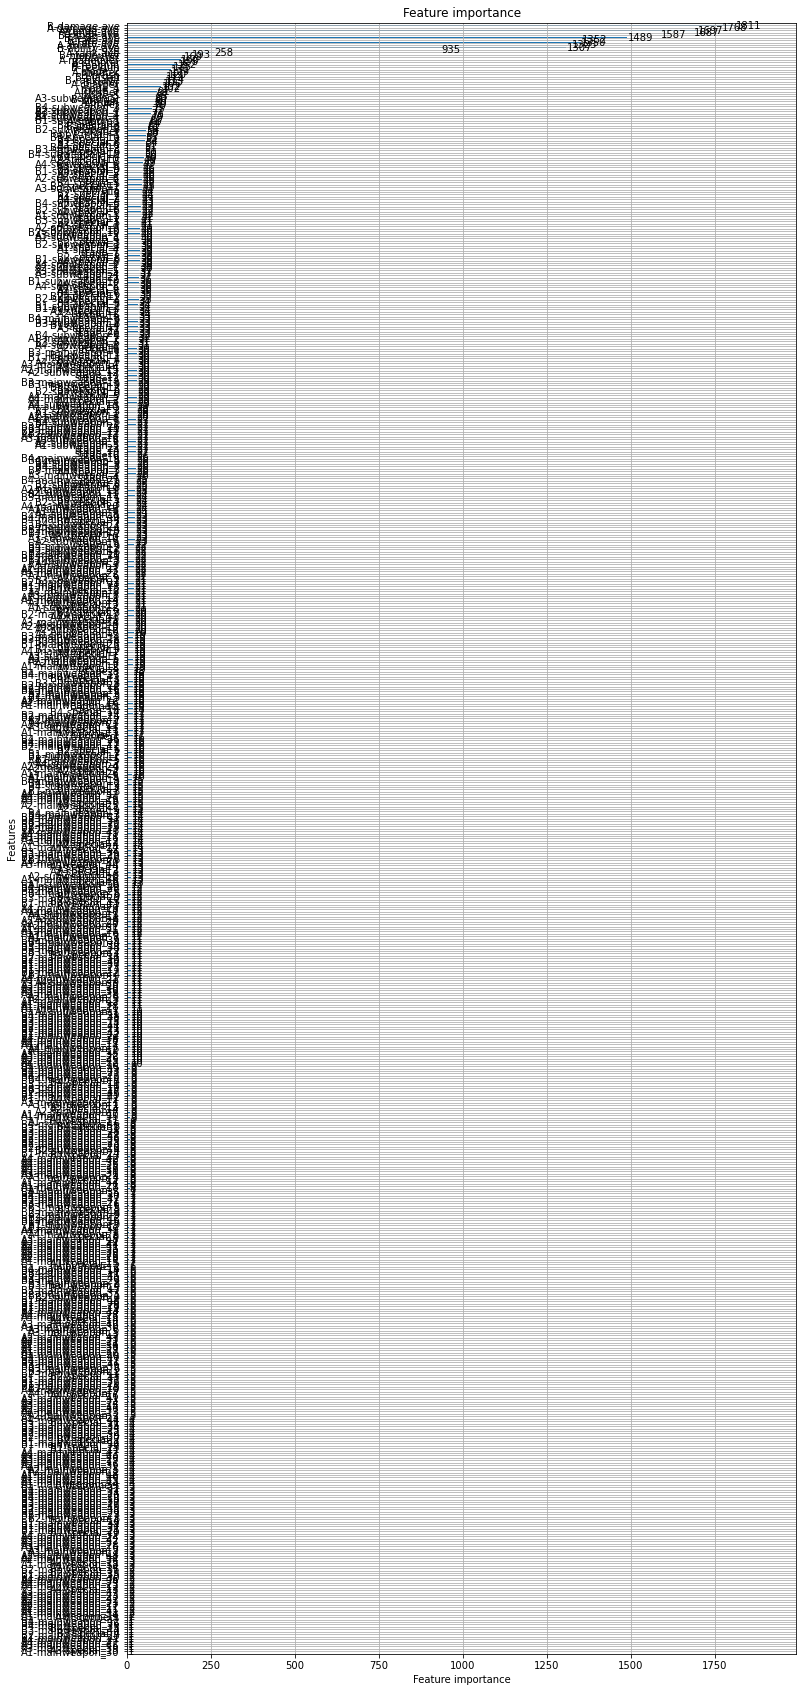

In [38]:
lgb.plot_importance(model, figsize=(12, 30))
plt.show()

In [36]:
# 提出用ファイルを作成する
pd.DataFrame({"id": range(len(pred_cv)), "y": pred_cv }).to_csv("../data/07_model_output/lightgbm_submission.csv", index=False)